In [1]:
import pandas as pd
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [58]:
import pandas as pd
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.metrics import mean_squared_error
import numpy as np

# Преобразование данных в формат datetime, устанавливая последнее число каждого месяца
data["Month"] = pd.to_datetime(data["Month"]).dt.to_period("M").dt.to_timestamp() + pd.offsets.MonthEnd(0)

# Определение последнего года для тестовой выборки
last_year = data["Month"].dt.year.max()

# Разделение данных: тренировочные (до последнего года) и тестовые (последний год)
train_data = data[data["Month"].dt.year < last_year]
test_data = data[data["Month"].dt.year == last_year]

# Подготовка данных для Prophet
train_df = train_data.rename(columns={"Month": "ds", "#Passengers": "y"})[["ds", "y"]]

# Обучение модели Prophet
# Создание модели Prophet с настройками гиперпараметров
model = Prophet(
    growth='linear',              # Тип тренда: 'linear' или 'logistic'
    changepoint_prior_scale=0.03,  # Степень чувствительности к изменениям (обычно от 0.001 до 0.5)
    seasonality_prior_scale=10.0,   # Степень чувствительности к сезонности
    holidays_prior_scale=10.0,       # Степень чувствительности к праздникам
    yearly_seasonality=True,        # Использовать годовую сезонность (True/False)
    weekly_seasonality=True,         # Использовать недельную сезонность (True/False)
    daily_seasonality=False,         # Использовать ежедневную сезонность (True/False)
    seasonality_mode='multiplicative',    # Режим сезонности: 'additive' или 'multiplicative'
)




model.fit(train_df)

# Создание прогноза на 12 месяцев вперёд
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Отбор прогнозов для тестового года
forecast_test = forecast[forecast["ds"].dt.year == last_year]

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(test_data["#Passengers"], forecast_test["yhat"]))
print(f"Среднеквадратичная ошибка (RMSE) на тестовой выборке: {rmse:.2f}")


17:20:19 - cmdstanpy - INFO - Chain [1] start processing
17:20:19 - cmdstanpy - INFO - Chain [1] done processing


Среднеквадратичная ошибка (RMSE) на тестовой выборке: 22.90


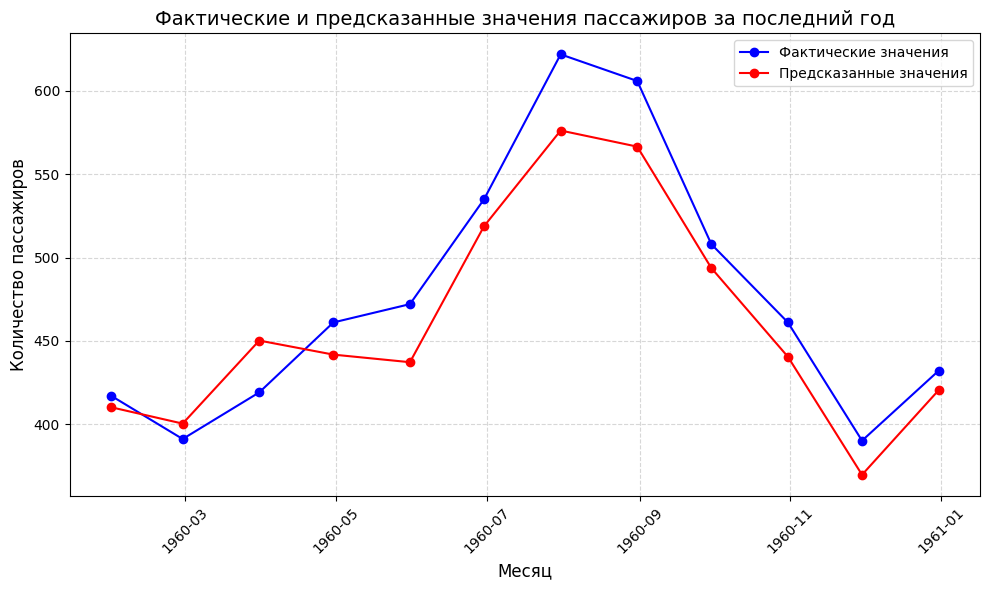

In [25]:
import matplotlib.pyplot as plt

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_data["Month"], test_data["#Passengers"], marker='o', label="Фактические значения", color="blue")
plt.plot(forecast_test["ds"], forecast_test["yhat"], marker='o', label="Предсказанные значения", color="red")

# Добавление заголовка и подписей к осям
plt.title("Фактические и предсказанные значения пассажиров за последний год", fontsize=14)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("Количество пассажиров", fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()
